In [70]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import tensorflow as tf

from tensorflow import keras
import tensorflow_addons as tfa

In [47]:
#Importing target feature
y = pd.read_csv('./Resources/critic_meta_score.csv')
y.drop(['index'], inplace = True, axis =1)
y

,critic_meta_score
0,100.0
1,100.0
2,100.0
3,100.0
4,100.0
...,...
8772,25.0
8773,20.0
8774,10.0
8775,0.0


In [48]:
#Impoting input features
X = pd.read_csv('./Resources/emotion_scores.csv')
X.drop(['index'], inplace = True, axis =1)
X

,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy
0,0.041667,0.000000,0.208333,0.041667,0.208333,0.041667,0.083333,0.041667,0.166667
1,0.090909,0.045455,0.227273,0.045455,0.181818,0.136364,0.045455,0.090909,0.045455
2,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.250000,0.000000,0.000000
3,0.037037,0.037037,0.222222,0.074074,0.222222,0.111111,0.037037,0.037037,0.111111
4,0.090909,0.090909,0.000000,0.090909,0.272727,0.181818,0.181818,0.090909,0.000000
...,...,...,...,...,...,...,...,...,...
8772,0.166667,0.166667,0.166667,0.000000,0.000000,0.333333,0.166667,0.000000,0.000000
8773,0.000000,0.000000,0.285714,0.000000,0.285714,0.142857,0.000000,0.000000,0.142857
8774,0.000000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.000000,0.125000
8775,0.090909,0.090909,0.090909,0.000000,0.090909,0.272727,0.272727,0.000000,0.000000


In [49]:
# Create a list of the columns and put in a variable
emotions = X.columns.to_list()
emotions

['fear',
 'anger',
 'trust',
 'surprise',
 'positive',
 'negative',
 'sadness',
 'disgust',
 'joy']

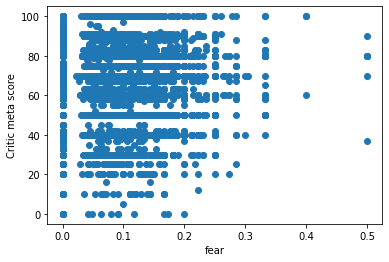

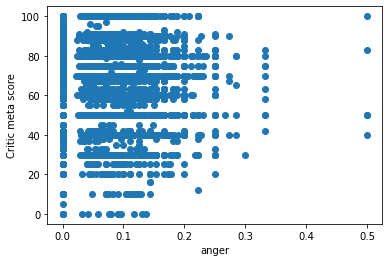

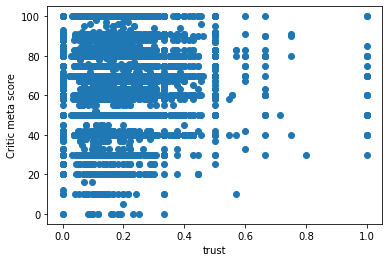

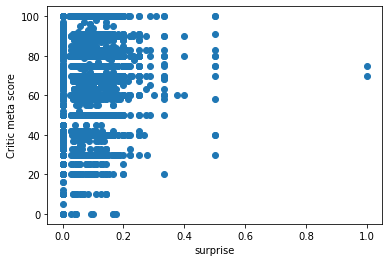

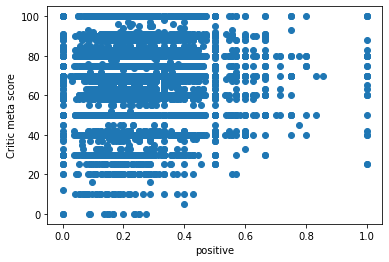

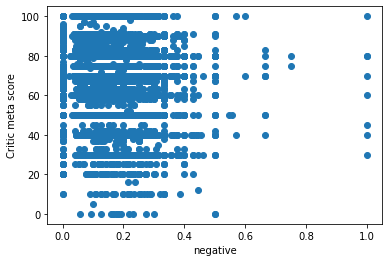

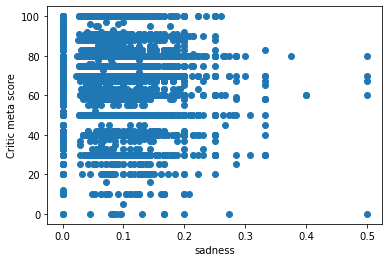

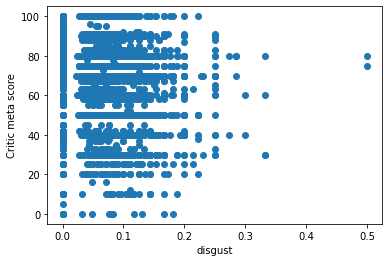

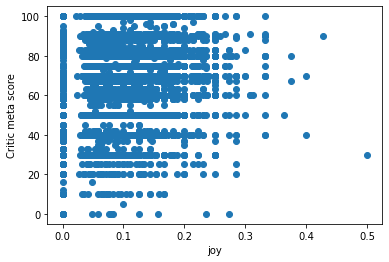

In [50]:
# Loop through the emotion variable to plot scatter plots
for emotion in emotions:
    plt.scatter(X[emotion], y.critic_meta_score)
    plt.xlabel(str(emotion))
    plt.ylabel('Critic meta score')
    plt.show()

In [77]:
for emotion in emotions:
    my_rho = np.corrcoef(X[emotion], y.critic_meta_score)
    print(f'{emotion}: {my_rho[1][0]}')
    print('--------')


fear: 0.0003510990804016408
--------
anger: -0.040270521368143054
--------
trust: 0.019499055396198936
--------
surprise: 0.06628844890194316
--------
positive: 0.07735684586309982
--------
negative: -0.1405926666866013
--------
sadness: -0.09350031064878674
--------
disgust: -0.0851843070864095
--------
joy: 0.10196552193146763
--------


In [51]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [52]:
# Create an instance of the model
model = LinearRegression()

In [53]:
# Fit and train the the model
model.fit(X_train, y_train)

LinearRegression()

In [54]:
# show the predictions for the model
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print(y_pred_train.shape)
print(y_pred_test.shape)

(6143, 1)
(2634, 1)


In [55]:
print(model.coef_)

[[ 24.92376492  17.97672394   3.86580161  23.26589821  10.36117401
  -11.14001064 -12.29032147 -11.4789197   21.12624982]]


In [56]:
print(model.intercept_)

[61.21137449]


In [57]:
print(model.score(X_train, y_train))

0.03100619130902904


In [58]:
print(model.score(X_test, y_test))

0.03404279227543461


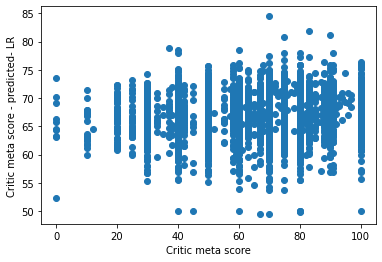

In [59]:
# Create a scatter plot showing the predicted values vs the actual values
plt.scatter(y_train, y_pred_train)
plt.xlabel('Critic meta score')
plt.ylabel('Critic meta score - predicted- LR')
plt.show()

In [60]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

/Users/mitchell/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


 Random forest predictive accuracy: 0.126


In [66]:
#Calculating R2 for Random Forest Classifier

r2_score(y_test,y_pred)

-0.6280097746530477

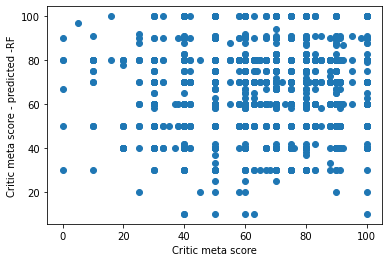

In [68]:
# Create a scatter plot showing the predicted values vs the actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Critic meta score')
plt.ylabel('Critic meta score - predicted -RF')
plt.show()

In [42]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [43]:
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor = 'val_loss',
    mode = 'min',
    verbose=1,
    save_best_only=True,
    save_weights_only=True)


# Define the model - deep neural net
number_input_features = X_train.shape[1]
hidden_nodes_layer1 = 26
hidden_nodes_layer2 = 13
hidden_nodes_layer3 = 6

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="mean_squared_error", optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=["mean_squared_error"])


In [44]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=500,callbacks=[cp_callback])

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/500
192/192 [==============================] - 1s 3ms/step - loss: 1138.7009 - mean_squared_error: 1138.7009
Epoch 2/500
192/192 [==============================] - 0s 2ms/step - loss: 361.1274 - mean_squared_error: 361.1274
Epoch 3/500
192/192 [==============================] - 0s 2ms/step - loss: 364.2354 - mean_squared_error: 364.2354
Epoch 4/500
192/192 [==============================] - 0s 2ms/step - loss: 365.8592 - mean_squared_error: 365.8592
Epoch 5/500
192/192 [==============================] - 0s 2ms/step - loss: 362.2588 - mean_squared_error: 362.2588
Epoch 6/500
192/192 [==============================] - 0s 2ms/step - loss: 359.1761 - mean_squared_error: 359.1761
Epoch 7/500
192/192 [==============================] - 0s 2ms/step - loss: 361.6443 - mean_squared_error: 361.6443
Epoch 8/500
192/192 [==============================] - 0s 2ms/step - loss: 359.5833 - mean_squared_error: 359.5833
Epoch 9/500
192/192 [==============================] - 0s 2ms/step - loss: 358

KeyboardInterrupt: 

In [ ]:
# Export our model to HDF5 file
nn.save("./Resources/TV_shows_NN.h5")

In [ ]:
# Loading the model from the h5 file
nn = keras.models.load_model("./Resources/TV_shows_NN.h5")

In [ ]:
# Defining true y values and predicted y values for test set
y_true = y_test
y_pred = model.predict(X_test)


In [ ]:
# Calculating the R2
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_true, y_pred)
result = metric.result()
result.np()

In [ ]:
# Create a scatter plot showing the predicted values vs the actual values
plt.scatter(y_true, y_pred)
plt.xlabel('Critic meta score')
plt.ylabel('Critic meta score - predicted- NN')
plt.show()

In [ ]:
# Checking the model structure
nn.summary()